# CASA Summary
The pipeline used for calibration and flagging closely follows that of the CASA pipeline (https://casaguides.nrao.edu/index.php?title=VLA-S-CASA_Pipeline-CASA6.2.1#Stage_7._hifv_checkflag:_Flag_possible_RFI_on_BP_calibrator_using_rflag). This notebook summarises the output of the pipeline (calibration tables, flagging summaries, data plots) and can be used to get an overview of the data and identify bad data that needs to be flagged manually.

In [1]:
import os
import sys
import h5py
import yaml
import casatasks
import numpy as np
from astropy.time import Time
import astropy.units as u
from ipywidgets import interact

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = mpl.cm.viridis  
cmap.set_bad(color='red')

from IPython.display import Image

# read yaml file
with open("../input/config.yaml", "r") as file:
    conf = yaml.safe_load(file)
    
sys.path.append(os.path.join(os.curdir, "../"))

from vlapy import vladata, inspect

## Obervation Information 
The data below is the output of CASA's listobs task and can be used to fill in the yaml file "obs.yaml", which contains all the parameters for the pipeline.

In [2]:
obs = conf["obs list"][2]
root = os.path.join(conf["root"], f"{obs}")
name = obs.split(".")[0]

ms = os.path.join(root, f"{obs}_hanning.ms")
vladata.listobs(ms)

BeginTime
58740.975069444445 

EndTime
58741.067175925935 

IntegrationTime
7958.000000953674 

field_0
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': -2.7439275295795866}, 'm1': {'unit': 'rad', 'value': 0.5324852109}, 'refer': 'J2000', 'type': 'direction'}
name :  3C286


field_1
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': -2.8340755408795864}, 'm1': {'unit': 'rad', 'value': 0.5645353905000001}, 'refer': 'J2000', 'type': 'direction'}
name :  J1310+3220


field_10
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': -2.4068577622795866}, 'm1': {'unit': 'rad', 'value': 0.7601194933}, 'refer': 'J2000', 'type': 'direction'}
name :  QSO J1448+4333


field_11
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': -2.5478762759795868}, 'm1': {'unit': 'rad', 'value': 0.6063876327}, 'refer': 'J2000', 'type': 'direction'}
name :  J1416+3444


field_12
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': -2.6052915171795865}, 'm1': {'unit': 'rad', 'value': 0

### Array Layout

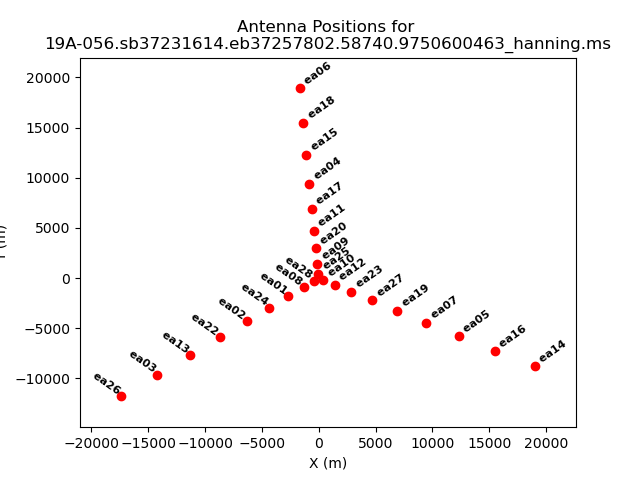

In [3]:
Image(filename=root + "/plots/obsplots/antlayout.png")

### Plot Elevation vs. Time
Observations low in elevation might see more RFI. The plot is colorised by field. Each target field is in between two phase calibrators.

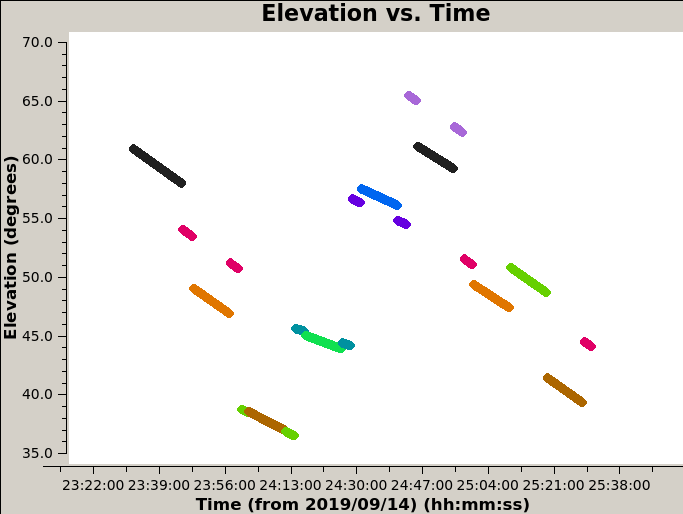

In [4]:
Image(filename=root + "/plots/obsplots/elevation_vs_time.png")

## VLA Deterministic Flags and Manual Flags
These include antennas not on source, shadowed antennas, scans with non-relevant intents, autocorrelations, edge channels of spectral windows, edge channels of the baseband, clipping absolute zero values produced by the correlator and the first few integrations of a scan (quacking). Manual flags are also applied for data known to be bad (RFI, obs reports). Below is a summary of the flags before and after applying the deterministic flags. Use the flagging frequency to find a suitable reference antenna and specify it in the yaml file.

In [5]:
summary_before = np.load(root + "/output/detflag_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + "/output/detflag_summary_after.npy", allow_pickle='TRUE').item()

# print flagging summary
def print_summary(item):
    for subitem in summary_before[item]:
        print(f"{item} {subitem}")
        print(
            "Before: {:.4f}, After: {:.4f}".format(
                100.0 * summary_before[item][subitem]["flagged"] / summary_before[item][subitem]["total"],
                100.0 * summary_after[item][subitem]["flagged"] / summary_after[item][subitem]["total"],
            )
        )
        print("")
        
print("Flag occupancy (percent) before and after deterministic flags:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after deterministic flags:

field 3C286
Before: 16.0891, After: 33.4054

field J1146+5356
Before: 18.9874, After: 35.7849

field J1310+3220
Before: 10.3372, After: 28.3222

field J1313+6735
Before: 14.6057, After: 31.7416

field J1416+3444
Before: 16.2376, After: 33.0364

field J1419+5423
Before: 14.7853, After: 32.3370

field J1506+3730
Before: 21.9306, After: 37.6023

field QSO J1148+5251
Before: 3.6194, After: 23.3397

field QSO J1250+3130
Before: 5.0483, After: 24.0873

field QSO J1257+6349
Before: 4.7189, After: 23.8229

field QSO J1401+2749
Before: 6.2464, After: 25.0462

field QSO J1402+4024
Before: 5.5614, After: 24.5059

field QSO J1427+3312
Before: 6.2021, After: 25.0176

field QSO J1429+5447
Before: 3.7957, After: 23.3321

field QSO J1448+4333
Before: 6.0614, After: 24.9028

scan 1
Before: 100.0000, After: 100.0000

scan 10
Before: 18.6427, After: 34.9761

scan 11
Before: 4.7189, After: 23.8229

scan 12
Before: 9.8050, After: 27.8951

scan

### Plot Online Flags
Plot flaggingreason vs. time. This shows which antennas are flagged due to focus errors, subreflector errors and antenna not on source. This plot can help identify suitable reference antennas.

In [6]:
if os.path.exists(root+"/plots/dataplots/flaggingreason_vs_time.png"):
    Image(filename=root+"/plots/dataplots/flaggingreason_vs_time.png")

### Plot Antenna Data Stream
If an antenna has missing data, it should not be used as a reference.

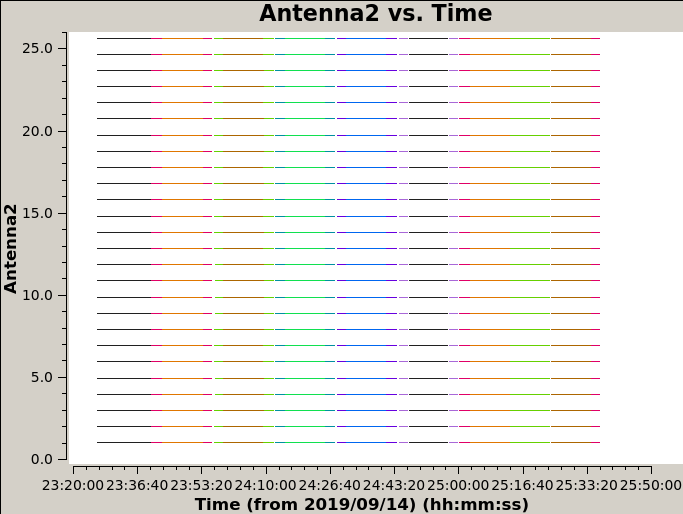

In [7]:
Image(filename=root + "/plots/obsplots/data_stream.png")

## Find Dead Antennas
Antennas that have low power should be flagged. This is also a good time to check for suitable reference antennas.

In [8]:
def plot_dead_ants(ant):
    plotfile = root + f"/plots/dataplots/find_dead_ants_amp_vs_freq_ant_{ant}.png"
    img = mpimg.imread(plotfile)
    plt.imshow(img)
    
interact(plot_dead_ants, ant=(1, 26))
    

interactive(children=(IntSlider(value=13, description='ant', max=26, min=1), Output()), _dom_classes=('widget-…

<function __main__.plot_dead_ants(ant)>

## RFI Inspection
The visibility amplitudes are first averaged across baselines and polarisation products. A modified Z-score is then computed across time as $Z_i = \frac{x_i - \mathrm{med}\{x_i\}_i}{\sigma_\mathrm{MAD}}$, 

where $\sigma_\mathrm{MAD} = \mathrm{med}\{\left|x_i - \mathrm{med}\{x_i\}_i\right|\}$ is the Median Absolute Deviation (MAD), and $x_i$ is the data (visibility amplitude) of the $i^\mathrm{th}$ integration.

The resulting Z-score is a spectrogram with dimensions of time and frequency. It can further be averaged across one of these dimensions to obtain a time series or a spectrum, which are useful for identifying broadband and persistent narrowband RFI respectively.

Use this to identify one clean channel per spectral window which will be used for the initial gain calibration.

#### Load Data

In [9]:

with h5py.File(root + f"/output/z_score_data.h5", "r") as f:
    z_score = f["z-score avg"][()]
    flags = f["flags avg"][()]
    freq_array = f["freq array"][()]
    time_array = f["time array"][()]
    ant_pairs = f["ant pairs"][()]
    dt = f["dt"][()]

# Load time integrations per scan
ntimes_file = os.path.join(root, f"output/ntimes.txt")
ntimes = np.loadtxt(ntimes_file).astype(int)

# time array
tisot = np.unique(Time(time_array, format="jd", scale="utc").isot)

z_score = np.ma.masked_array(z_score, mask=flags)

#### Plot

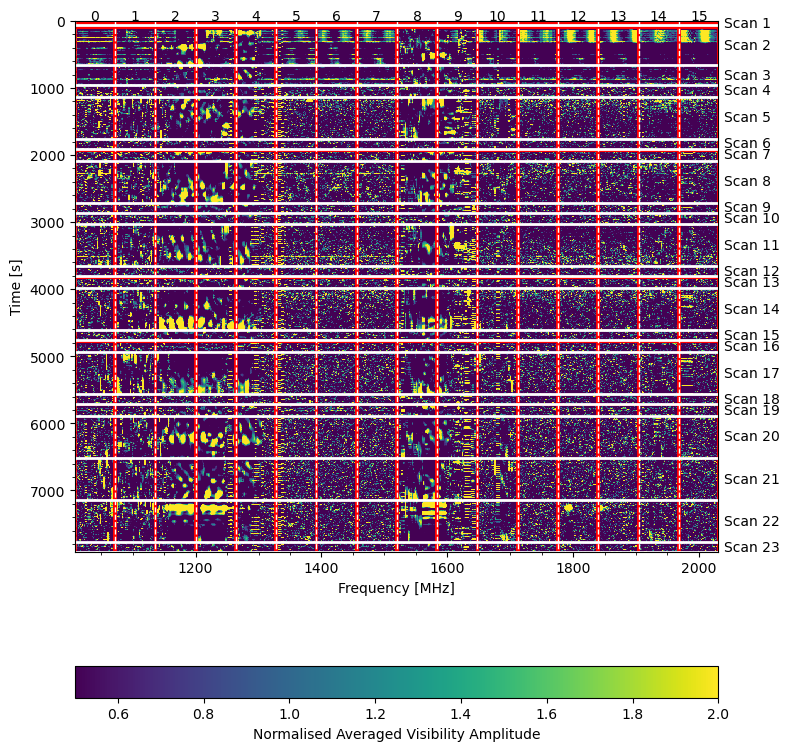

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
ax, im = inspect.plot_wf(freq_array, z_score, 2, ntimes, vmin=0.5, vmax=2, cmap=cmap, ax=ax, plot_masked=True)
fig.colorbar(im, orientation="horizontal", label="Normalised Averaged Visibility Amplitude")
plt.tight_layout()
plt.show()

In [11]:
def plot_wf_spw(i):
    inspect.plot_wf_spw(freq_array, z_score, i, 2, ntimes, plot_masked=True)
    
interact(plot_wf_spw, i=(0, 15))

interactive(children=(IntSlider(value=7, description='i', max=15), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_wf_spw(i)>

In [12]:
summary_before = np.load(root + "/output/manual_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + "/output/manual_flags_summary_after.npy", allow_pickle='TRUE').item()
        
print("Flag occupancy (percent) before and after manual flags:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after manual flags:

field 3C286
Before: 64.0371, After: 64.2175

field J1146+5356
Before: 67.5987, After: 67.5987

field J1310+3220
Before: 65.2465, After: 65.2465

field J1313+6735
Before: 66.3388, After: 66.3388

field J1416+3444
Before: 67.1007, After: 67.1007

field J1419+5423
Before: 67.0704, After: 67.0704

field J1506+3730
Before: 68.8020, After: 68.8020

field QSO J1148+5251
Before: 65.2867, After: 65.2867

field QSO J1250+3130
Before: 62.0535, After: 62.0535

field QSO J1257+6349
Before: 63.9439, After: 63.9439

field QSO J1401+2749
Before: 60.5399, After: 60.5399

field QSO J1402+4024
Before: 60.3674, After: 60.3674

field QSO J1427+3312
Before: 60.3183, After: 60.3183

field QSO J1429+5447
Before: 61.6091, After: 61.6091

field QSO J1448+4333
Before: 66.6823, After: 66.6823

scan 1
Before: 100.0000, After: 100.0000

scan 10
Before: 67.8407, After: 67.8407

scan 11
Before: 63.9439, After: 63.9439

scan 12
Before: 64.5527, After: 64.5527

s

## Flux Calibrator Model
Print model flux densities and plot model amplitude vs. uv-distance. If the calibrator is not resolved, its amplitude should be constant across different uv-distances. If it is slightly resolved, the amplitude will decrease as a function of uv-distance.

In [13]:
setjy = np.load(root + "/output/setjy.npy", allow_pickle='TRUE').item()

print("model flux densities in Jy\n")

for spw in range(16):
    print("SPW {:2d}: I: {:.2f}, U: {:.2f}, V: {:.2f}, Q: {:.2f}".format(spw, *setjy["0"][str(spw)]["fluxd"]))

model flux densities in Jy

SPW  0: I: 17.64, U: 0.00, V: 0.00, Q: 0.00
SPW  1: I: 17.15, U: 0.00, V: 0.00, Q: 0.00
SPW  2: I: 16.70, U: 0.00, V: 0.00, Q: 0.00
SPW  3: I: 16.27, U: 0.00, V: 0.00, Q: 0.00
SPW  4: I: 15.86, U: 0.00, V: 0.00, Q: 0.00
SPW  5: I: 15.49, U: 0.00, V: 0.00, Q: 0.00
SPW  6: I: 15.13, U: 0.00, V: 0.00, Q: 0.00
SPW  7: I: 14.79, U: 0.00, V: 0.00, Q: 0.00
SPW  8: I: 14.47, U: 0.00, V: 0.00, Q: 0.00
SPW  9: I: 14.16, U: 0.00, V: 0.00, Q: 0.00
SPW 10: I: 13.87, U: 0.00, V: 0.00, Q: 0.00
SPW 11: I: 13.60, U: 0.00, V: 0.00, Q: 0.00
SPW 12: I: 13.34, U: 0.00, V: 0.00, Q: 0.00
SPW 13: I: 13.09, U: 0.00, V: 0.00, Q: 0.00
SPW 14: I: 12.85, U: 0.00, V: 0.00, Q: 0.00
SPW 15: I: 12.62, U: 0.00, V: 0.00, Q: 0.00


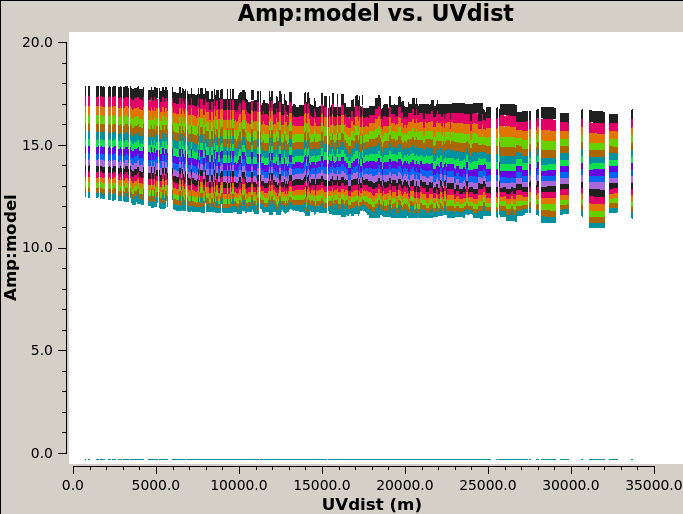

In [14]:
Image(filename=root + "/plots/calplots/setjy_model_amp_vs_uvdist.png")

## Prior Calibration

The prior calibration includes atmospheric opacity corrections, antenna offset corrections and requantizer (rq) gains. These are independent of calibrator observations and use external data instead.

### Weather
Plot weather data and print opacities. For frequencies below 10 GHz the opacity is negligibly small.  

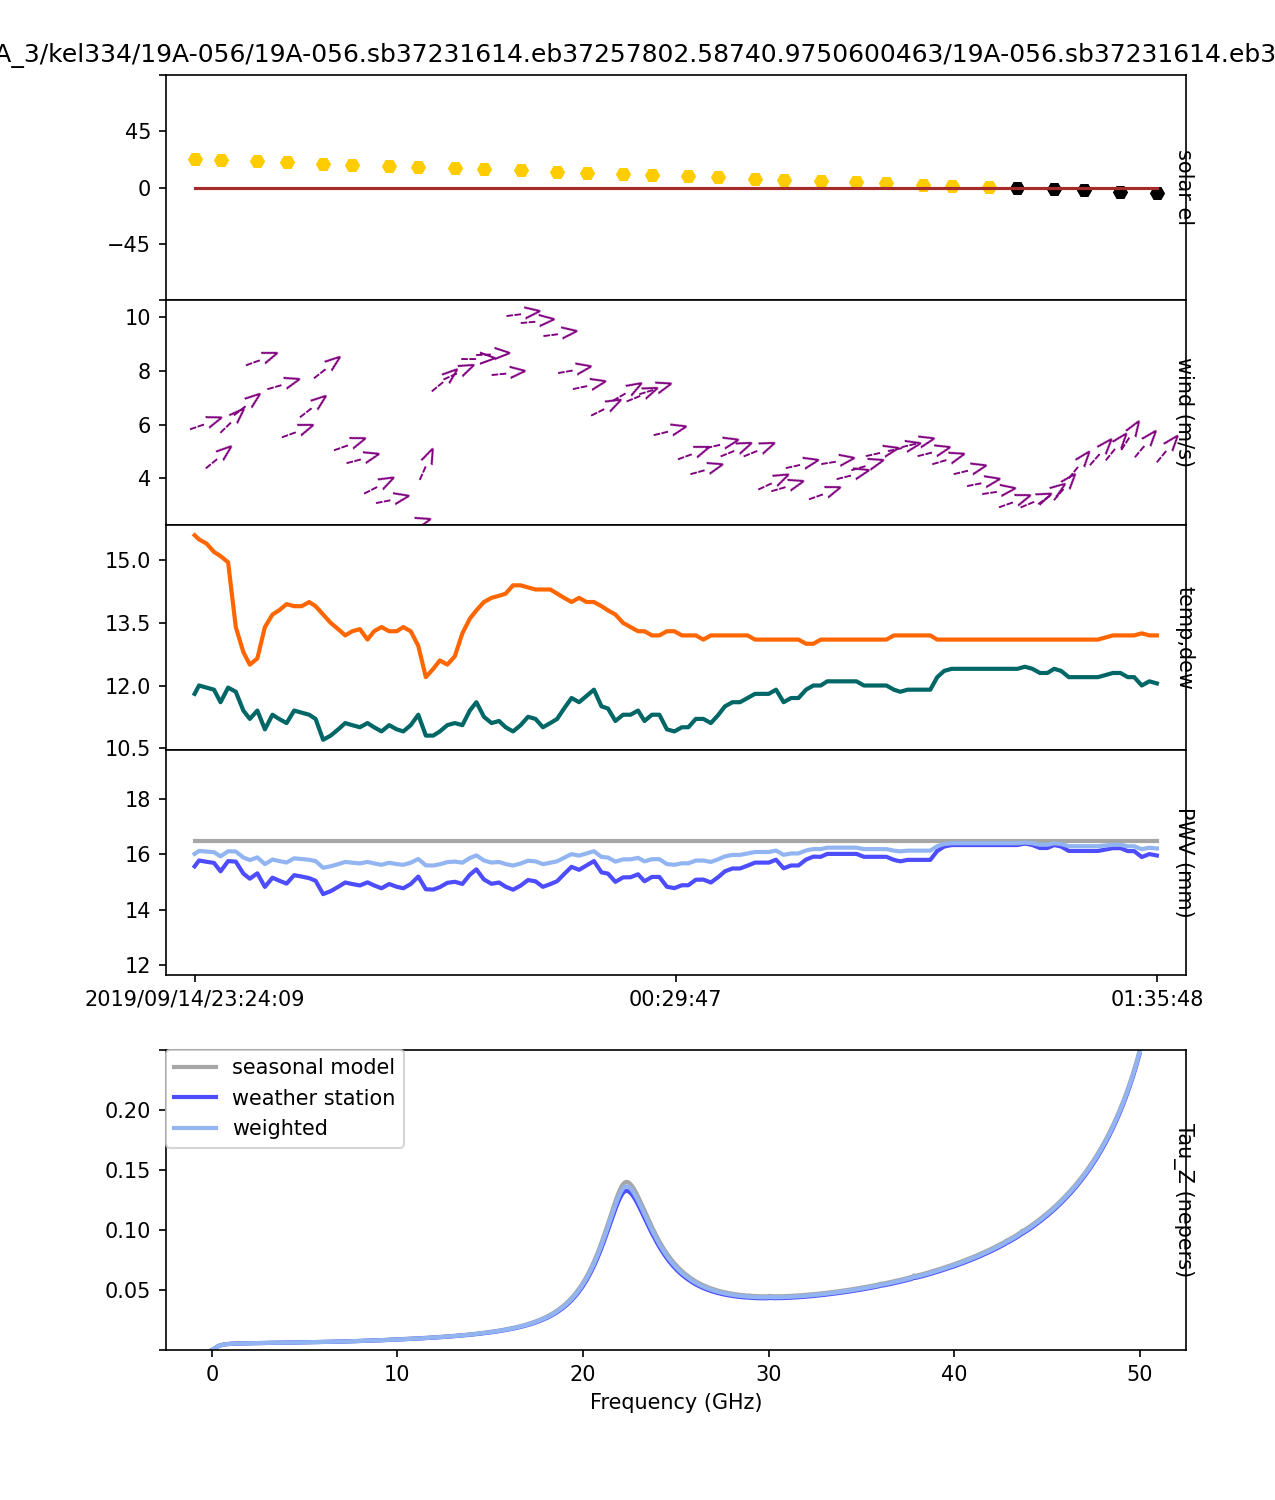

In [15]:
Image(filename=root + "/plots/calplots/weather.png")

In [16]:
opacities = np.load(root + "/output/weather.npy")

print("Opacities [Nepers]\n")

for spw, opacity in enumerate(opacities):
    print(f"SPW {spw}: {opacity}")

Opacities [Nepers]

SPW 0: 0.005155701878410441
SPW 1: 0.005215972643115074
SPW 2: 0.0052684753737757975
SPW 3: 0.005314435052678174
SPW 4: 0.005355288864651168
SPW 5: 0.005391634242792201
SPW 6: 0.005424402022150685
SPW 7: 0.005454066885957654
SPW 8: 0.0054811581523328615
SPW 9: 0.005506082609920971
SPW 10: 0.005529130780714909
SPW 11: 0.0055506493002615235
SPW 12: 0.005570787311755445
SPW 13: 0.0055898238220344525
SPW 14: 0.005607869935640107
SPW 15: 0.005625103933669607


## Plot Calibration Channels
These are the channels that have been selected for the gain calibration. They should be clean and should not exhibit any amplitude jumps.

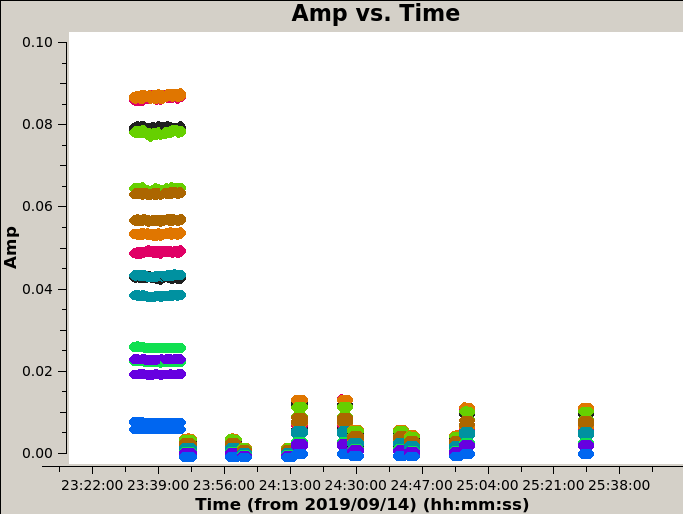

In [17]:
Image(filename=root + "/plots/dataplots/single_chans_amp_vs_time.png")

## Initial Calibration
The initial calibration is done to enable subsequent flagging with automated flagging routines such as CASA's RFlag. The calibration consists of an initial gain phase calibration, a delay calibration, an initial gain phase and amplitude calibration and a bandpass calibration. The two gain calibrations are used for the delay and bandpass calibrations, but are not applied to the data. The gain calibrations are done with a single channel per spectral window.

In [18]:
def plot_two_cols(im1, im2):
    """ 
    Plot two image side by side. E.g phase and amplitude.
    """
    fix, ax = plt.subplots(1, 2, figsize=(15, 5))

    if os.path.exists(im1):
        img_1 = mpimg.imread(im1)
        ax[0].imshow(img_1)

    if os.path.exists(im2):
        img_2 = mpimg.imread(im2)
        ax[1].imshow(img_2)

### Specify Gain Tables

In [19]:
# specify calibration table names
rnd = 0
delay_init_table = f"{name}.p.G{rnd}"
delay_table = f"{name}.K{rnd}"
bandpass_init_table = f"{name}.ap.G{rnd}"
bandpass_table = f"{name}.B{rnd}"

### Delay Initial Gain Calibration
This is an initial per-integration phase calibration and is done to avoid decorrelation under temporal averaging in the subsequent delay calibration. The gain phase should be stable in time. Antennas or spectral windows that have gain phase discontinuities should be flagged. If all but the reference antenna exhibit phase jumps, a difference reference antenna should be chosen.

In [20]:
def plot_delay_init_cal(ant):
    img = mpimg.imread(root + f"/plots/calplots/{delay_init_table}_ant_{ant}_Poln0,1.png")
    imgplot = plt.imshow(img)

interact(plot_delay_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_delay_init_cal(ant)>

### Delay Calibration
The delay calibration is done by fitting for the phase slopes across frequency with respect to the reference antenna. The first and last 15 channels of the spectral windows are not used in this step, since they have lower gains. The delays should lie between -5 and 5 ns, and anything outside that range should be treated with suspicion.

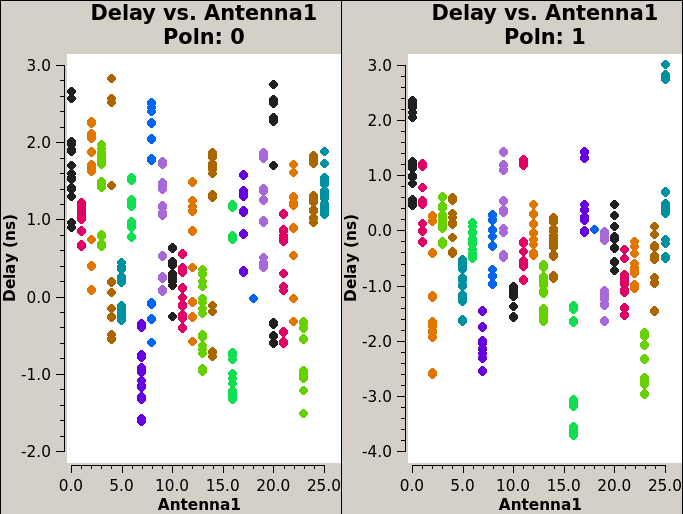

In [21]:
Image(filename=root + f"/plots/calplots/{delay_table}_Poln0,1.png")

### Bandpass Initial Gain Calibration
Similarly to above, we perform an initial gain calibration for the bandpass calibration, but this time we also solve for the amplitudes. The phases and amplitudes should be constant with time and discontinuous solutions should be flagged.

In [22]:
def plot_bandpass_init_cal(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_init_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_init_table}_phase_ant_{ant}_Poln0,1.png"
    )

interact(plot_bandpass_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_init_cal(ant)>

### Bandpass Calibration
The amplitudes and phases of the bandpass calibration should be close to 1 and zero respectively after the initial gain calibration. Discontinuities should be flagged.

In [23]:
def plot_bandpass_ant(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_ant_{ant}_Poln0,1.png"
    )
    
interact(plot_bandpass_ant, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_ant(ant)>

Iterate through spectral windows and colorise by antenna. 

In [24]:
def plot_bandpass_spw(spw):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_spw_{spw}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_spw_{spw}_Poln0,1.png"
    )

interact(plot_bandpass_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_bandpass_spw(spw)>

### Plot Corrected Data
This data is averaged in time and colorised by antenna.

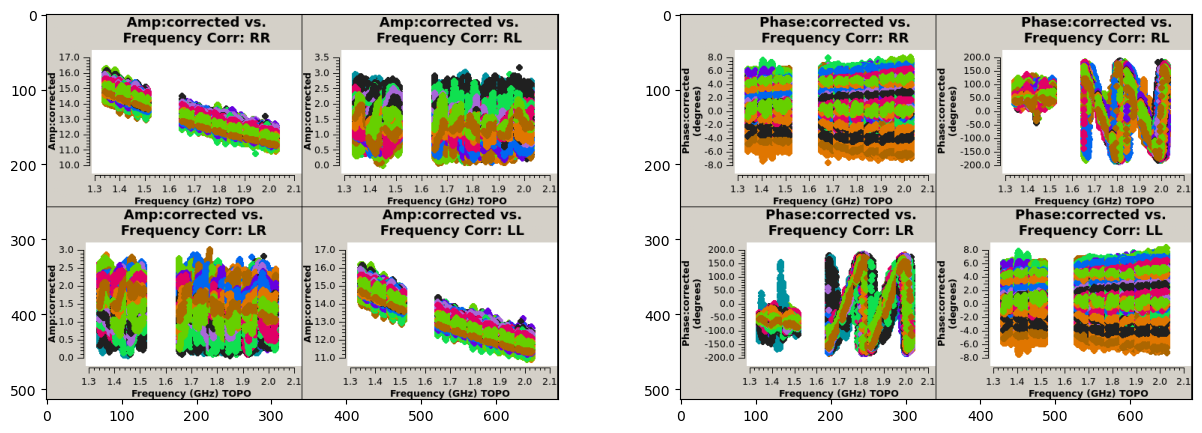

In [25]:
plot_two_cols(
    root + f"/plots/dataplots/fluxcal_initcal_round_0_amp_vs_freq_CorrRR,RL,LR,LL.png",
    root + f"/plots/dataplots/fluxcal_initcal_round_0_phase_vs_freq_CorrRR,RL,LR,LL.png"
)

#### Plot Averaged Corrected Data
Iterate through spectral windows to identify RFI and flag bad channels manually below.

In [26]:
def plot_corrected_spw(spw):
    img = mpimg.imread(root + f"/plots/dataplots/fluxcal_initcal_round_0_amp_vs_freq_avg_spw_{spw}_CorrRR,RL,LR,LL.png")
    plt.imshow(img)

interact(plot_corrected_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_corrected_spw(spw)>

### Flagging Summary
If no calibration solutions are available, data may be flagged (e.g. bad spectral windows).

In [27]:
rnd=0
summary_before = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print(f"Flag occupancy (percent) before and after initial calibration round {rnd}:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after initial calibration round 0:

field 3C286
Before: 64.2175, After: 64.2175

antenna ea01
Before: 61.2189, After: 61.2189

antenna ea02
Before: 61.0740, After: 61.0740

antenna ea03
Before: 61.0404, After: 61.0404

antenna ea04
Before: 61.1156, After: 61.1156

antenna ea05
Before: 61.0680, After: 61.0680

antenna ea06
Before: 61.0904, After: 61.0904

antenna ea07
Before: 61.0841, After: 61.0841

antenna ea08
Before: 61.2378, After: 61.2378

antenna ea09
Before: 61.2507, After: 61.2507

antenna ea10
Before: 61.3167, After: 61.3167

antenna ea11
Before: 61.1333, After: 61.1333

antenna ea12
Before: 61.1392, After: 61.1392

antenna ea13
Before: 61.0650, After: 61.0650

antenna ea14
Before: 60.9420, After: 60.9420

antenna ea15
Before: 61.1058, After: 61.1058

antenna ea16
Before: 100.0000, After: 100.0000

antenna ea17
Before: 61.1457, After: 61.1457

antenna ea18
Before: 66.1045, After: 66.1045

antenna ea19
Before: 61.0563, After: 61.0563

antenna

## First Round of Flagging on Primary Calibrator
The first round of flagging is performed on the primary calibrator only. The flagging routine runs RFlag with timedevscale=5.0, freqdevscale=5.0 and freqfit=line on a ABS_RL, ABS_LR, ABS_LL, ABS_RR, REAL_LL, REAL_RR, IMAG_LL and IMAG_RR, where for the real and imaginary parts RFLag is performed on the residual (corrected-model) data. TFCrop is run with timecutoff=4.0 and freqcutoff=4.0 on ABS_RL, ABS_LR, ABS_LL and ABS_RR. Flags are extended across polarisations. The plots below show the amplitudes and phases of the calibrators before and after flagging respectively.

### Before Flagging

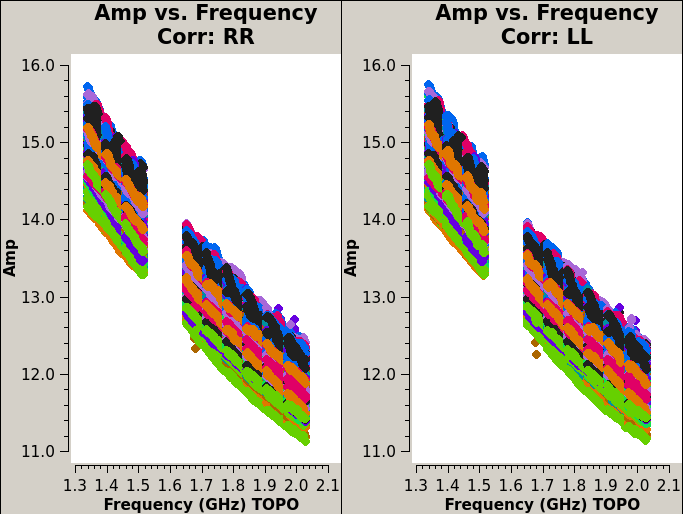

In [28]:
Image(filename=root + "/plots/dataplots/before_fluxcal_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

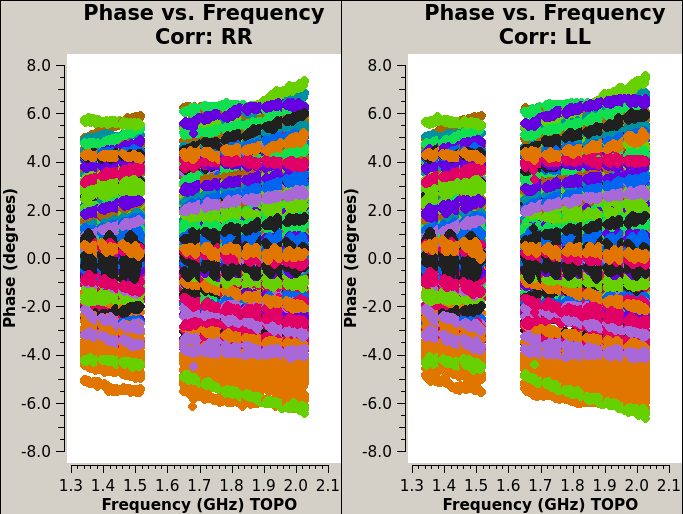

In [29]:
Image(filename=root + "/plots/dataplots/before_fluxcal_round_0_flagging_phase_vs_freq_CorrRR,LL.png")

### After Flagging

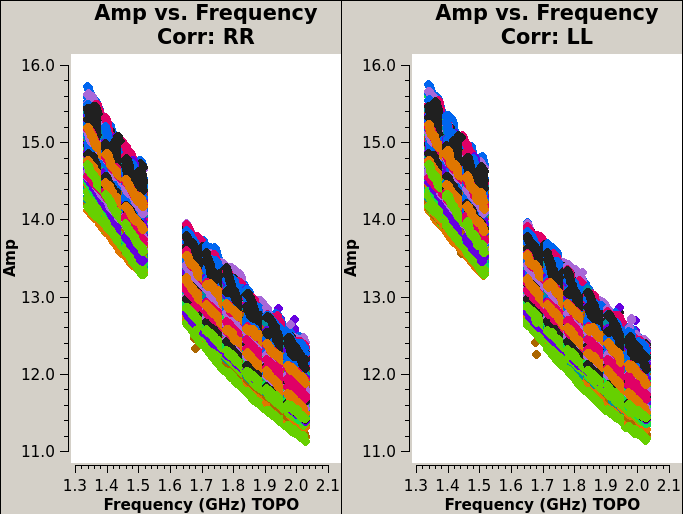

In [30]:
Image(filename=root + "/plots/dataplots/after_fluxcal_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

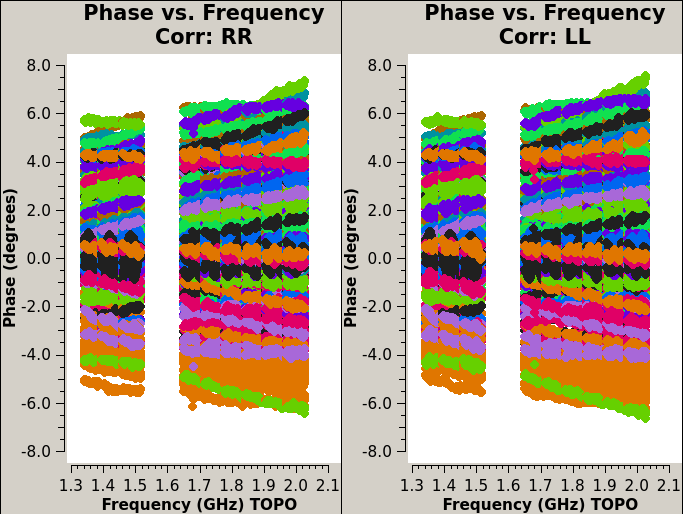

In [31]:
Image(filename=root + "/plots/dataplots/after_fluxcal_round_0_flagging_phase_vs_freq_CorrRR,LL.png")

### Summary

In [32]:
summary_before = np.load(root + f"/output/fluxcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/fluxcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flagging the flux calibrator:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after flagging the flux calibrator:

field 3C286
Before: 64.2175, After: 64.2187

antenna ea01
Before: 61.2189, After: 61.2190

antenna ea02
Before: 61.0740, After: 61.0740

antenna ea03
Before: 61.0404, After: 61.0404

antenna ea04
Before: 61.1156, After: 61.1159

antenna ea05
Before: 61.0680, After: 61.0733

antenna ea06
Before: 61.0904, After: 61.1037

antenna ea07
Before: 61.0841, After: 61.0872

antenna ea08
Before: 61.2378, After: 61.2392

antenna ea09
Before: 61.2507, After: 61.2509

antenna ea10
Before: 61.3167, After: 61.3195

antenna ea11
Before: 61.1333, After: 61.1336

antenna ea12
Before: 61.1392, After: 61.1411

antenna ea13
Before: 61.0650, After: 61.0650

antenna ea14
Before: 60.9420, After: 60.9430

antenna ea15
Before: 61.1058, After: 61.1061

antenna ea16
Before: 100.0000, After: 100.0000

antenna ea17
Before: 61.1457, After: 61.1458

antenna ea18
Before: 66.1045, After: 66.1046

antenna ea19
Before: 61.0563, After: 61.0563

antenn

## Semi-Final Calibration
The steps from the intitial calibration are repeated. 

### Specify Gain Tables

In [33]:
# specify calibration table names
rnd = 1
delay_init_table = f"{name}.p.G{rnd}"
delay_table = f"{name}.K{rnd}"
bandpass_init_table = f"{name}.ap.G{rnd}"
bandpass_table = f"{name}.B{rnd}"

### Delay Initial Gain Calibration

In [34]:
def plot_delay_init_cal(ant):
    img = mpimg.imread(root + f"/plots/calplots/{delay_init_table}_ant_{ant}_Poln0,1.png")
    imgplot = plt.imshow(img)

interact(plot_delay_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_delay_init_cal(ant)>

### Delay Calibration

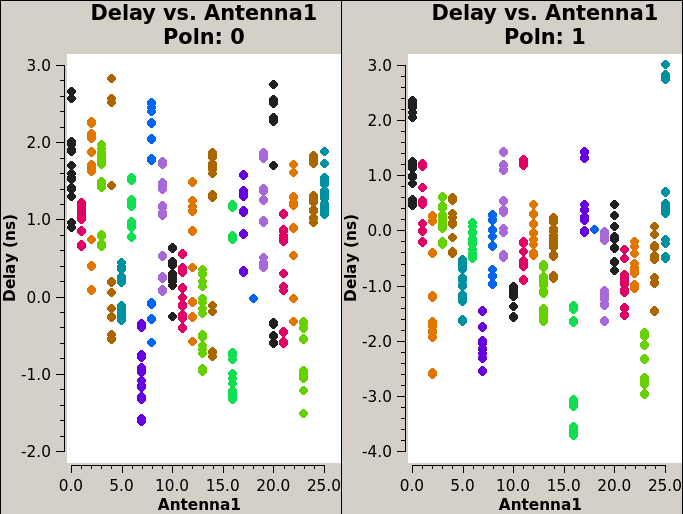

In [35]:
Image(filename=root + f"/plots/calplots/{delay_table}_Poln0,1.png")

### Bandpass Initial Gain Calibration

In [36]:
def plot_bandpass_init_cal(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_init_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_init_table}_phase_ant_{ant}_Poln0,1.png"
    )

interact(plot_bandpass_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_init_cal(ant)>

### Bandpass Calibration

In [37]:
def plot_bandpass_ant(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_ant_{ant}_Poln0,1.png"
    )
    
interact(plot_bandpass_ant, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_ant(ant)>

Iterate through spectral windows and colorise by antenna. 

In [38]:
def plot_bandpass_spw(spw):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_spw_{spw}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_spw_{spw}_Poln0,1.png"
    )

interact(plot_bandpass_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_bandpass_spw(spw)>

### Flagging Summary
If no calibration solutions are available, data may be flagged (e.g. bad spectral windows).

In [39]:
rnd=1
summary_before = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print(f"Flag occupancy (percent) before and after initial calibration round {rnd}:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after initial calibration round 1:

field 3C286
Before: 64.2187, After: 64.2187

antenna ea01
Before: 61.2190, After: 61.2190

antenna ea02
Before: 61.0740, After: 61.0740

antenna ea03
Before: 61.0404, After: 61.0404

antenna ea04
Before: 61.1159, After: 61.1159

antenna ea05
Before: 61.0733, After: 61.0733

antenna ea06
Before: 61.1037, After: 61.1037

antenna ea07
Before: 61.0872, After: 61.0872

antenna ea08
Before: 61.2392, After: 61.2392

antenna ea09
Before: 61.2509, After: 61.2509

antenna ea10
Before: 61.3195, After: 61.3195

antenna ea11
Before: 61.1336, After: 61.1336

antenna ea12
Before: 61.1411, After: 61.1411

antenna ea13
Before: 61.0650, After: 61.0650

antenna ea14
Before: 60.9430, After: 60.9430

antenna ea15
Before: 61.1061, After: 61.1061

antenna ea16
Before: 100.0000, After: 100.0000

antenna ea17
Before: 61.1458, After: 61.1458

antenna ea18
Before: 66.1046, After: 66.1046

antenna ea19
Before: 61.0563, After: 61.0563

antenna

## Second Round of Flagging
The flagging is repeated, but this time on all calibrators.

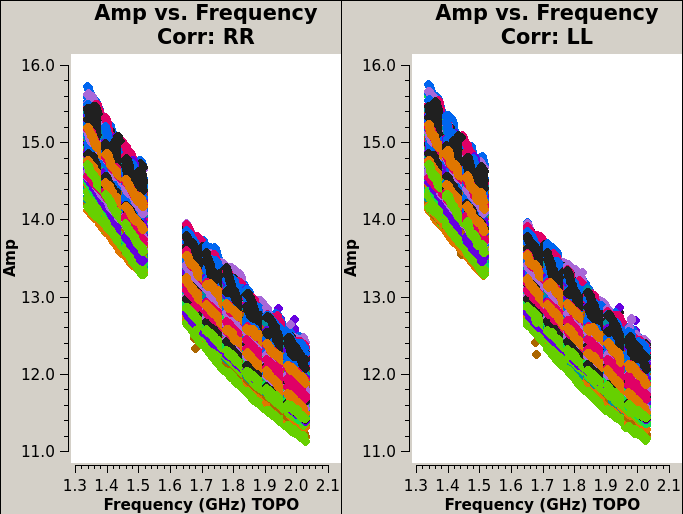

In [40]:
# primary calibrator
Image(filename=root + "/plots/dataplots/before_fluxcal_round_1_flagging_amp_vs_freq_CorrRR,LL.png")

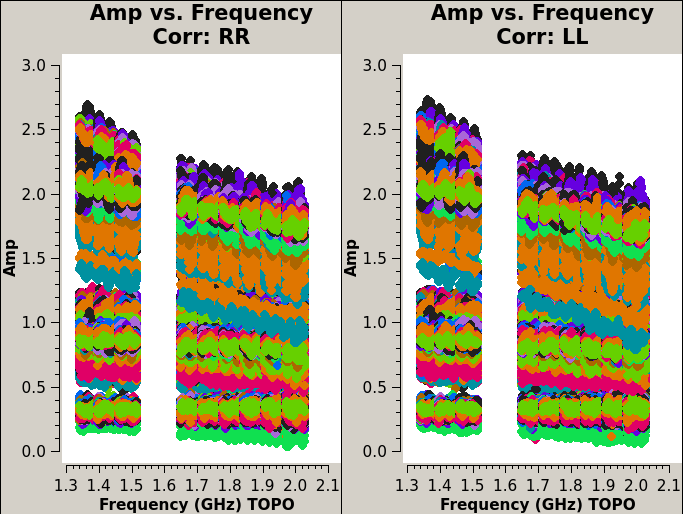

In [41]:
# phase calibrators
Image(filename=root + "/plots/dataplots/before_phasecal_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

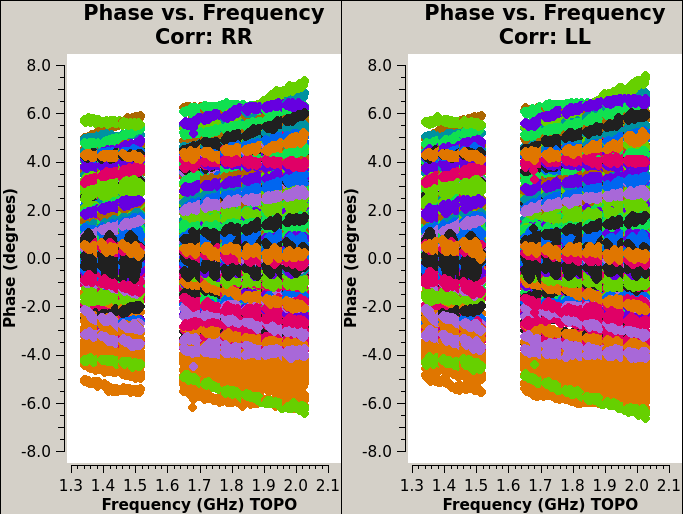

In [42]:
# primary calibrator
Image(filename=root + "/plots/dataplots/before_fluxcal_round_1_flagging_phase_vs_freq_CorrRR,LL.png")

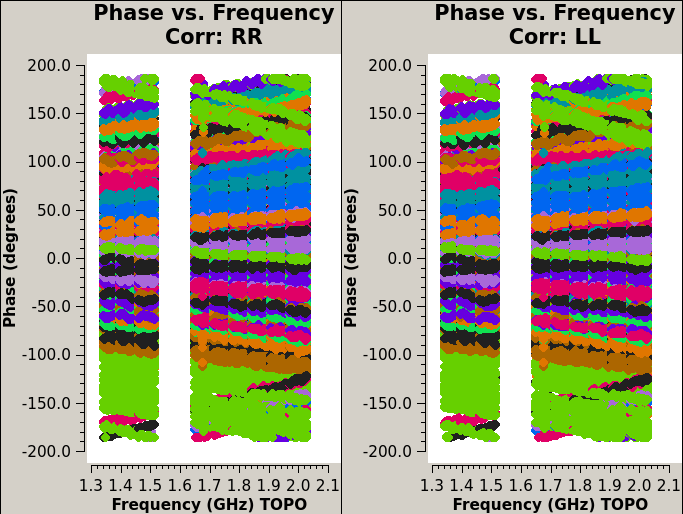

In [43]:
# phase calibrators
Image(filename=root + "/plots/dataplots/before_phasecal_round_0_flagging_phase_vs_freq_CorrRR,LL.png")

### After Flagging

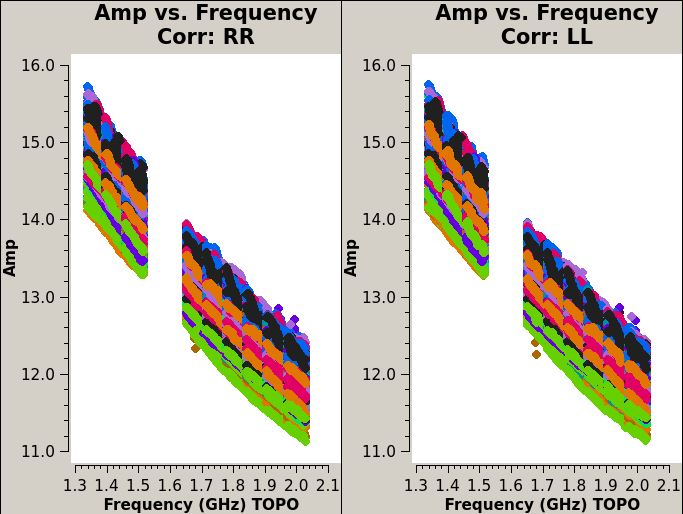

In [44]:
# primary calibrator
Image(filename=root + "/plots/dataplots/after_fluxcal_round_1_flagging_amp_vs_freq_CorrRR,LL.png")

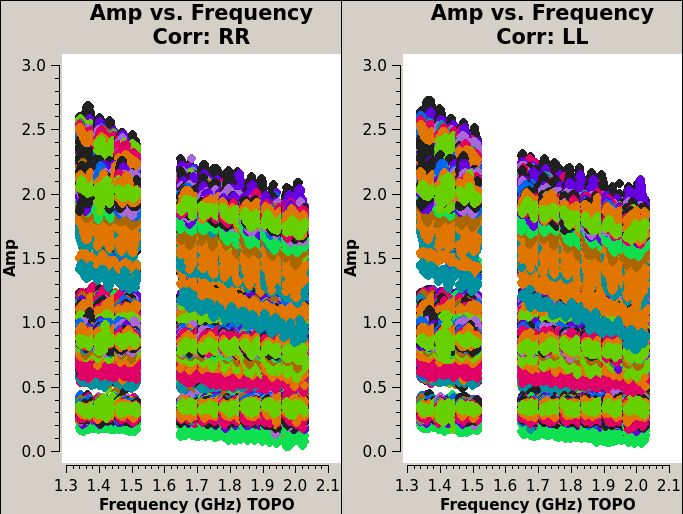

In [45]:
# phase calibrators
Image(filename=root + "/plots/dataplots/after_phasecal_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

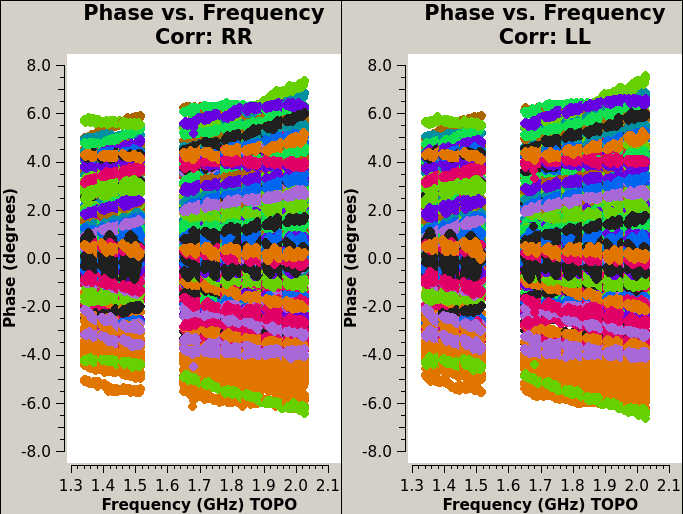

In [46]:
# primary calibrator
Image(filename=root + "/plots/dataplots/after_fluxcal_round_1_flagging_phase_vs_freq_CorrRR,LL.png")

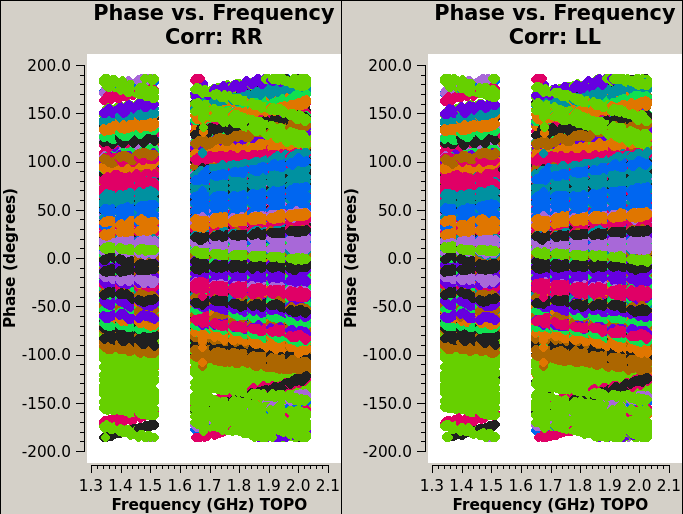

In [47]:
# phase calibrators
Image(filename=root + "/plots/dataplots/after_phasecal_round_0_flagging_phase_vs_freq_CorrRR,LL.png")

### Flagging Summary

In [48]:
summary_before = np.load(root + f"/output/fluxcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/fluxcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flagging the flux calibrator:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after flagging the flux calibrator:

field 3C286
Before: 64.2187, After: 64.2229

scan 1
Before: 100.0000, After: 100.0000

scan 2
Before: 63.4074, After: 63.4115

scan 3
Before: 58.8465, After: 58.8517

antenna ea01
Before: 61.2190, After: 61.2206

antenna ea02
Before: 61.0740, After: 61.0746

antenna ea03
Before: 61.0404, After: 61.0420

antenna ea04
Before: 61.1159, After: 61.1192

antenna ea05
Before: 61.0733, After: 61.0821

antenna ea06
Before: 61.1037, After: 61.1358

antenna ea07
Before: 61.0872, After: 61.0943

antenna ea08
Before: 61.2392, After: 61.2460

antenna ea09
Before: 61.2509, After: 61.2526

antenna ea10
Before: 61.3195, After: 61.3270

antenna ea11
Before: 61.1336, After: 61.1370

antenna ea12
Before: 61.1411, After: 61.1540

antenna ea13
Before: 61.0650, After: 61.0665

antenna ea14
Before: 60.9430, After: 60.9460

antenna ea15
Before: 61.1061, After: 61.1079

antenna ea16
Before: 100.0000, After: 100.0000

antenna ea17
Before: 6

In [49]:
summary_before = np.load(root + f"/output/phasecal_round_0_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/phasecal_round_0_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flagging the phase calibrators:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after flagging the phase calibrators:

field J1146+5356
Before: 67.5987, After: 67.8449

field J1310+3220
Before: 65.2465, After: 65.6494

field J1313+6735
Before: 66.3388, After: 66.7835

field J1416+3444
Before: 67.1007, After: 67.5086

field J1419+5423
Before: 67.0704, After: 67.4553

field J1506+3730
Before: 68.8020, After: 69.1914

scan 10
Before: 67.8407, After: 68.2838

scan 12
Before: 64.5527, After: 64.9993

scan 13
Before: 68.9230, After: 69.2730

scan 15
Before: 64.8423, After: 65.2693

scan 16
Before: 71.5601, After: 71.9332

scan 18
Before: 65.4848, After: 65.8938

scan 19
Before: 69.5233, After: 69.8906

scan 23
Before: 64.2198, After: 64.6760

scan 4
Before: 66.0979, After: 66.4953

scan 6
Before: 64.2226, After: 64.6320

scan 7
Before: 73.0825, After: 73.2937

scan 9
Before: 61.0034, After: 61.2917

antenna ea01
Before: 64.9043, After: 65.5519

antenna ea02
Before: 64.4334, After: 64.9255

antenna ea03
Before: 64.2734, After: 64.7428


In [50]:
summary_before = np.load(root + f"/output/phasecal_MAD_clipping_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/phasecal_MAD_clipping_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flagging MAD clippting the phase calibrators:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after flagging MAD clippting the phase calibrators:

field J1146+5356
Before: 66.9795, After: 67.0606

field J1310+3220
Before: 64.6190, After: 64.7548

field J1313+6735
Before: 65.6775, After: 65.8270

field J1416+3444
Before: 66.4226, After: 66.5605

field J1419+5423
Before: 66.4282, After: 66.5572

field J1506+3730
Before: 68.2410, After: 68.3700

scan 10
Before: 67.2000, After: 67.3491

scan 12
Before: 63.8670, After: 64.0169

scan 13
Before: 68.3355, After: 68.4526

scan 15
Before: 64.1342, After: 64.2776

scan 16
Before: 71.0496, After: 71.1725

scan 18
Before: 64.8631, After: 64.9995

scan 19
Before: 68.9113, After: 69.0344

scan 23
Before: 63.4631, After: 63.6186

scan 4
Before: 65.5070, After: 65.6408

scan 6
Before: 63.5509, After: 63.6892

scan 7
Before: 72.5737, After: 72.6422

scan 9
Before: 60.2515, After: 60.3475

antenna ea01
Before: 64.1985, After: 64.4178

antenna ea02
Before: 63.7338, After: 63.8994

antenna ea03
Before: 63.4974, A

## Final Calibration
First, the initial calibration (delay and bandpass) are repeated on the primary calibrator. Then, the final gains of the calibrators are derived.

### Specify Gain Tables

In [51]:
# specify calibration table names
rnd = 2
delay_init_table = f"{name}.p.G{rnd}"
delay_table = f"{name}.K{rnd}"
bandpass_init_table = f"{name}.ap.G{rnd}"
bandpass_table = f"{name}.B{rnd}"

fluxcal_phase_table = f"{name}_fluxcal_phase.Gfinal"
short_gain_table = f"{name}_short.Gfinal"
amp_gain_table = f"{name}_amp.Gfinal"
phase_gain_table = f"{name}_phase.Gfinal"

### Delay Initial Gain Calibration

In [52]:
def plot_delay_init_cal(ant):
    img = mpimg.imread(root + f"/plots/calplots/{delay_init_table}_ant_{ant}_Poln0,1.png")
    imgplot = plt.imshow(img)

interact(plot_delay_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_delay_init_cal(ant)>

### Delay Calibration

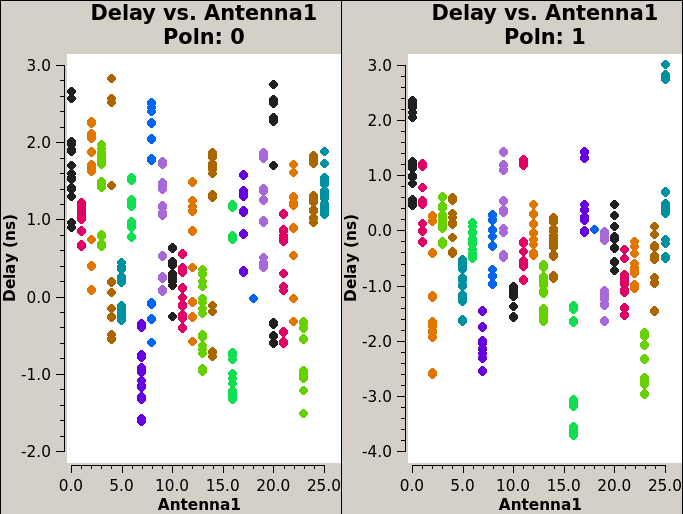

In [53]:
Image(filename=root + f"/plots/calplots/{delay_table}_Poln0,1.png")

### Bandpass Initial Gain Calibration

In [54]:
def plot_bandpass_init_cal(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_init_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_init_table}_phase_ant_{ant}_Poln0,1.png"
    )

interact(plot_bandpass_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_init_cal(ant)>

### Bandpass Calibration

In [55]:
def plot_bandpass_ant(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_ant_{ant}_Poln0,1.png"
    )
    
interact(plot_bandpass_ant, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_ant(ant)>

Iterate through spectral windows and colorise by antenna. 

In [56]:
def plot_bandpass_spw(spw):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_spw_{spw}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_spw_{spw}_Poln0,1.png"
    )

interact(plot_bandpass_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_bandpass_spw(spw)>

### Flux Calibrator Final Gain Phase

In [57]:
def plot_final_fluxcal_phase(ant):
    img = mpimg.imread(root + f'/plots/calplots/{fluxcal_phase_table}_ant_{ant}_Poln0,1.png')
    plt.imshow(img)

interact(plot_final_fluxcal_phase, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_fluxcal_phase(ant)>

### Short Interval Gain Calibration
This is an initial calibration done on a per-integration basis on the calibrators.

In [58]:
def plot_final_short_gain_phase(ant):
    img = mpimg.imread(root + f'/plots/calplots/{short_gain_table}_phase_ant_{ant}_Poln0,1.png')
    plt.imshow(img)

interact(plot_final_short_gain_phase, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_short_gain_phase(ant)>

### Long Interval Gain Calibration
The gain amplitudes of the calibrators of solved for using the initial gain phase calibration above.

In [59]:
def plot_final_long_gain(ant):
    plot_two_cols(
        root + f'/plots/calplots/{amp_gain_table}_amp_ant_{ant}_Poln0,1.png',
        root + f'/plots/calplots/{amp_gain_table}_phase_ant_{ant}_Poln0,1.png'
    )

interact(plot_final_long_gain, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_long_gain(ant)>

### Phase Calibration
Derive the final gain phases of the calibrators. That of the primary calibrator should be close to zero, since it was already derived and applied earlier on.

In [60]:
def plot_final_phase(ant):
    img = mpimg.imread(root + f'/plots/calplots/{phase_gain_table}_phase_ant_{ant}_Poln0,1.png')
    plt.imshow(img)

interact(plot_final_phase, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_phase(ant)>

### Flagging Summary

In [61]:
rnd=1
summary_before = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print(f"Flag occupancy (percent) before and after final delay and bandpass calibration:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after final delay and bandpass calibration:

field 3C286
Before: 64.2187, After: 64.2187

antenna ea01
Before: 61.2190, After: 61.2190

antenna ea02
Before: 61.0740, After: 61.0740

antenna ea03
Before: 61.0404, After: 61.0404

antenna ea04
Before: 61.1159, After: 61.1159

antenna ea05
Before: 61.0733, After: 61.0733

antenna ea06
Before: 61.1037, After: 61.1037

antenna ea07
Before: 61.0872, After: 61.0872

antenna ea08
Before: 61.2392, After: 61.2392

antenna ea09
Before: 61.2509, After: 61.2509

antenna ea10
Before: 61.3195, After: 61.3195

antenna ea11
Before: 61.1336, After: 61.1336

antenna ea12
Before: 61.1411, After: 61.1411

antenna ea13
Before: 61.0650, After: 61.0650

antenna ea14
Before: 60.9430, After: 60.9430

antenna ea15
Before: 61.1061, After: 61.1061

antenna ea16
Before: 100.0000, After: 100.0000

antenna ea17
Before: 61.1458, After: 61.1458

antenna ea18
Before: 66.1046, After: 66.1046

antenna ea19
Before: 61.0563, After: 61.0563

In [62]:
summary_before = np.load(root + f"/output/applycal_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/applycal_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after applying final calibration:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after applying final calibration:

field 3C286
Before: 64.2233, After: 64.2233

field J1146+5356
Before: 67.8451, After: 67.8451

field J1310+3220
Before: 65.6496, After: 65.6496

field J1313+6735
Before: 66.7835, After: 66.7835

field J1416+3444
Before: 67.5089, After: 67.5089

field J1419+5423
Before: 67.4553, After: 67.4553

field J1506+3730
Before: 69.1914, After: 69.1914

field QSO J1148+5251
Before: 65.2867, After: 65.2867

field QSO J1250+3130
Before: 62.0535, After: 62.0535

field QSO J1257+6349
Before: 63.9439, After: 63.9439

field QSO J1401+2749
Before: 60.5403, After: 60.5403

field QSO J1402+4024
Before: 60.3674, After: 60.3674

field QSO J1427+3312
Before: 60.3183, After: 60.3183

field QSO J1429+5447
Before: 61.6091, After: 61.6091

field QSO J1448+4333
Before: 66.6823, After: 66.6823

scan 1
Before: 100.0000, After: 100.0000

scan 10
Before: 68.2838, After: 68.2838

scan 11
Before: 63.9439, After: 63.9439

scan 12
Before: 64.9993, Aft

## Target Flags
Now that the final calibration tables have been derived and applied to the data, the automated flagging routine is run on the target fields.

### Before Flagging

In [63]:
Image(filename=root + "/plots/dataplots/before_targets_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

FileNotFoundError: [Errno 2] No such file or directory: '/DATA/CARINA_3/kel334/19A-056/19A-056.sb37231614.eb37257802.58740.9750600463/plots/dataplots/before_targets_round_0_flagging_amp_vs_freq_CorrRR,LL.png'

### After Flagging

In [ ]:
Image(filename=root + "/plots/dataplots/after_targets_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

### Summary

In [ ]:
rnd=0
summary_before = np.load(root + f"/output/targets_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/targets_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) after flagging the flux calibrator:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

## Summary Plots
These plots show the corrected amplitudes and phases of all fields as a function of uv-distance and frequency. The values plotted against uv-distance are colorised by spectral window while those plotted against frequency are colorised by antenna number. Remaining RFI should be flagged manually in CASA.

In [ ]:
field_dict = vladata.get_field_names(ms)
fields = field_dict["calibrators"] + "," + field_dict["targets"]

In [ ]:
for field in fields.split(","):
    print(field)
    img = mpimg.imread(root + f"/plots/dataplots/{field}_amp_vs_uvdist_corrected.png")
    imgplot = plt.imshow(img)
    plt.show()

In [ ]:
for field in fields.split(","):
    print(field)
    img = mpimg.imread(root + f"/plots/dataplots/{field}_amp_vs_freq_corrected.png")
    imgplot = plt.imshow(img)
    plt.show()

In [ ]:
for field in fields.split(","):
    print(field)
    img = mpimg.imread(root + f"/plots/dataplots/{field}_phase_vs_freq_corrected.png")
    imgplot = plt.imshow(img)
    plt.show()

In [ ]:

with h5py.File(root + f"/output/z_score_corrected.h5", "r") as f:
    z_score = f["z-score avg"][()]
    flags = f["flags avg"][()]
    freq_array = f["freq array"][()]
    time_array = f["time array"][()]
    ant_pairs = f["ant pairs"][()]
    dt = f["dt"][()]

# Load time integrations per scan
ntimes_file = os.path.join(root, f"output/ntimes.txt")
ntimes = np.loadtxt(ntimes_file).astype(int)

# time array
tisot = np.unique(Time(time_array, format="jd", scale="utc").isot)

z_score = np.ma.masked_array(z_score, mask=flags)

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True)
ax = inspect.plot_time_series(tisot, np.ma.median(z_score, axis=1), ax, plot_masked=True)
ax.set_ylabel("Averaged Z-Score (unitless)")
ax.set_xticks(tisot[::100])
plt.tight_layout()

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
ax, im = inspect.plot_wf(freq_array, z_score, 2, ntimes, vmin=3, vmax=4, cmap=cmap, ax=ax, plot_masked=True)
fig.colorbar(im, orientation="horizontal", pad=0.08, label="Normalised Averaged Visibility Amplitude")